<a href="https://colab.research.google.com/github/palinkapro/ML_ZoomCamp/blob/main/Homework_unit_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-04 12:58:18--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.2’

CreditScoring.csv.2 100%[===================>] 178.21K  --.-KB/s    in 0.003s  

2021-10-04 12:58:18 (50.1 MB/s) - ‘CreditScoring.csv.2’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [8]:
df

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,1,rent,60,39,married,no,fixed,69,92,0,0,900,1020,1
4450,22,owner,60,46,married,no,fixed,60,75,3000,600,950,1263,0
4451,0,owner,24,37,married,no,partime,60,90,3500,0,500,963,1
4452,0,rent,48,23,single,no,freelance,49,140,0,0,550,550,0


In [9]:
categorical = ['home', 'marital', 'records', 'job']
numerical = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [10]:
from sklearn.model_selection import train_test_split

X_origin = df.drop(columns=['default'])
y_origin = df['default']
X, X_test, y, y_test = train_test_split(X_origin, y_origin, test_size=0.2, shuffle=True, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=1)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

In [11]:
from sklearn.metrics import roc_auc_score
scores = []
for num in numerical:
    if roc_auc_score(y_train, X_train[num]) < 0.5:
        scores.append(roc_auc_score(y_train, -X_train[num]))
    else:
        scores.append(roc_auc_score(y_train, X_train[num]))
print(numerical[np.argmax(scores)])

seniority


## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [12]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [13]:
subset = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [14]:
X_train_sub = X_train[subset]
X_val_sub = X_val[subset]

In [15]:
train_dict_sub = X_train_sub.to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_sub)

X_train_sub = dv_small.transform(train_dict_sub)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_sub, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [16]:
val_dict_sub = X_val_sub.to_dict(orient='records')
X_val_sub = dv_small.transform(val_dict_sub)

y_pred_sub = model.predict_proba(X_val_sub)[:, 1]

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [17]:
round(roc_auc_score(y_val, y_pred_sub), 3)

0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [18]:
thresholds = np.linspace(0.0, 1.0, 100, endpoint=False)
arr_precision = []
arr_recall = []
for threshold in thresholds:
    true_positive = ((y_pred_sub >= threshold) & (y_val == 1)).sum()
    false_positive = ((y_pred_sub >= threshold) & (y_val == 0)).sum()
    false_negative = ((y_pred_sub < threshold) & (y_val == 1)).sum()
    true_negative = ((y_pred_sub < threshold) & (y_val == 0)).sum()
    tp_fp = (true_positive + false_positive)
    tp_fn = (true_positive + false_negative)

    precision = round(true_positive / tp_fp, 2)
    recall = round(true_positive / tp_fn, 2)
    arr_precision.append(precision)
    arr_recall.append(recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

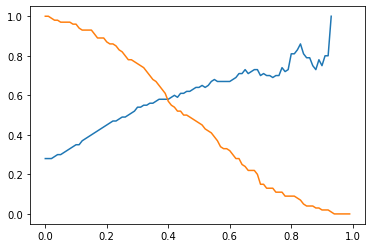

In [19]:
plt.plot(thresholds, arr_precision)
plt.plot(thresholds, arr_recall)

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [20]:
thresholds = np.linspace(0.0, 1.0, 100, endpoint=False)
arr_f1 = []
for threshold in thresholds:
    true_positive = ((y_pred_sub >= threshold) & (y_val == 1)).sum()
    false_positive = ((y_pred_sub >= threshold) & (y_val == 0)).sum()
    false_negative = ((y_pred_sub < threshold) & (y_val == 1)).sum()
    true_negative = ((y_pred_sub < threshold) & (y_val == 0)).sum()
    tp_fp = (true_positive + false_positive)
    tp_fn = (true_positive + false_negative)

    precision = round(true_positive / tp_fp, 2)
    recall = round(true_positive / tp_fn, 2)
    f1 = 2 * (precision * recall) / (precision + recall)
    arr_f1.append(f1)
scores = [x for x in arr_f1 if str(x) != 'nan']
print(thresholds[np.argmax(scores)])

0.3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value 

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [21]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [22]:
def train(df, y):
    cat = df[subset].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[subset].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [23]:
aucs = []

for train_idx, val_idx in kfold.split(df):
    df_train = df.iloc[train_idx]
    y_train = df_train.default.values

    df_val = df.iloc[val_idx]
    y_val = df_val.default.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [24]:
np.array(aucs).round(3)

array([0.776, 0.801, 0.826, 0.812, 0.795])

In [25]:
print('auc = %0.3f' % (np.std(aucs)))

auc = 0.017


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [26]:
def train(df, y, C=1.0):
    cat = df[subset].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return dv, model

In [27]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df):
        df_train = df.iloc[train_idx]
        df_val = df.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.01, auc = 0.798 ± 0.021
C=0.1, auc = 0.805 ± 0.021
C=1, auc = 0.802 ± 0.017
C=10, auc = 0.805 ± 0.020


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [28]:
import sklearn
sklearn.__version__


'1.0'

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.